In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp2d

In [5]:
from qutip import *

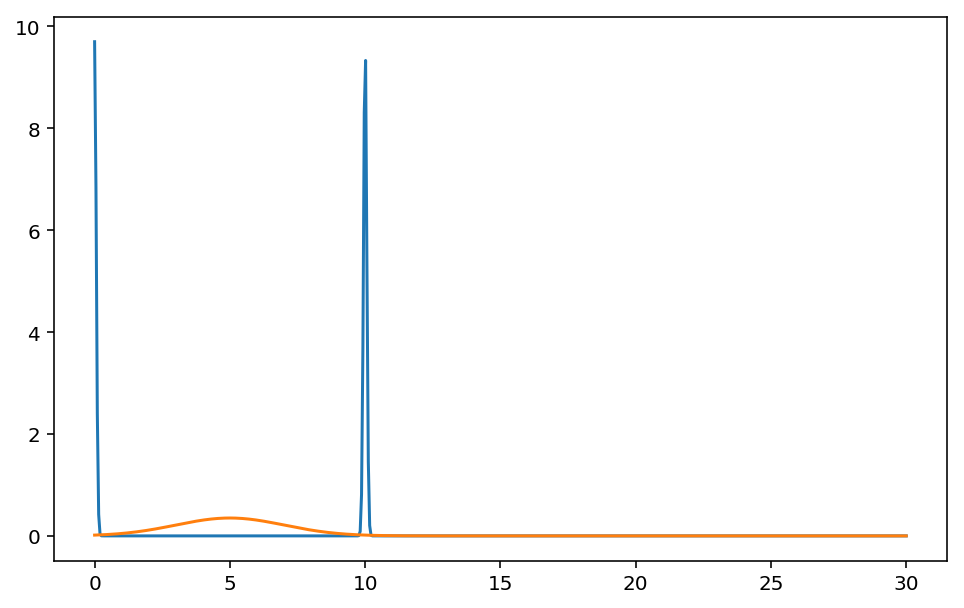

In [6]:
# shared parameters
gamma = 2 # decay rate
tlist = np.linspace(0, 30, 600)
taulist = tlist
# parameters for TLS with exponential shape wavepacket (short pulse)
tp_e = 0.060 # Gaussian pulse parameter
Om_e = 19.40 # driving strength
#t_offset_e = 0.405
t_offset_e = 0
pulse_shape_e = Om_e/2 * np.exp(-(tlist - t_offset_e-0) ** 2 /
(2 * tp_e ** 2)) + Om_e/2 * np.exp(-(tlist - 10 - t_offset_e) ** 2 /
(2 * tp_e ** 2))
# parameters for TLS with Gaussian shape wavepacket (long pulse)
tp_G = 2.000 # Gaussian pulse parameter
Om_G = 0.702 # driving strength
t_offset_G = 5
pulse_shape_G = Om_G/2 * np.exp(-(tlist - t_offset_G) ** 2 /
(2 * tp_G ** 2))

fig0, ax0 = plt.subplots(figsize=(8,5))
ax0.plot(tlist,pulse_shape_e)
ax0.plot(tlist,pulse_shape_G)

In [7]:
# initial state
psi0 = fock(2, 0) # ground state
# operators
sm = destroy(2) # atomic lowering operator
n = sm.dag()*sm # number operator
# Hamiltonian
H_I = sm + sm.dag()
H_e = [[H_I, pulse_shape_e]]
H_G = [[H_I, pulse_shape_G]]
# collapse operator that describes dissipation
c_ops = [np.sqrt(gamma) * sm] # represents spontaneous emission

In [8]:
n_e = mesolve(H_e, psi0, tlist, c_ops, n).expect[0]
#n_G = mesolve(H_G, psi0, tlist, c_ops, n).expect[0]

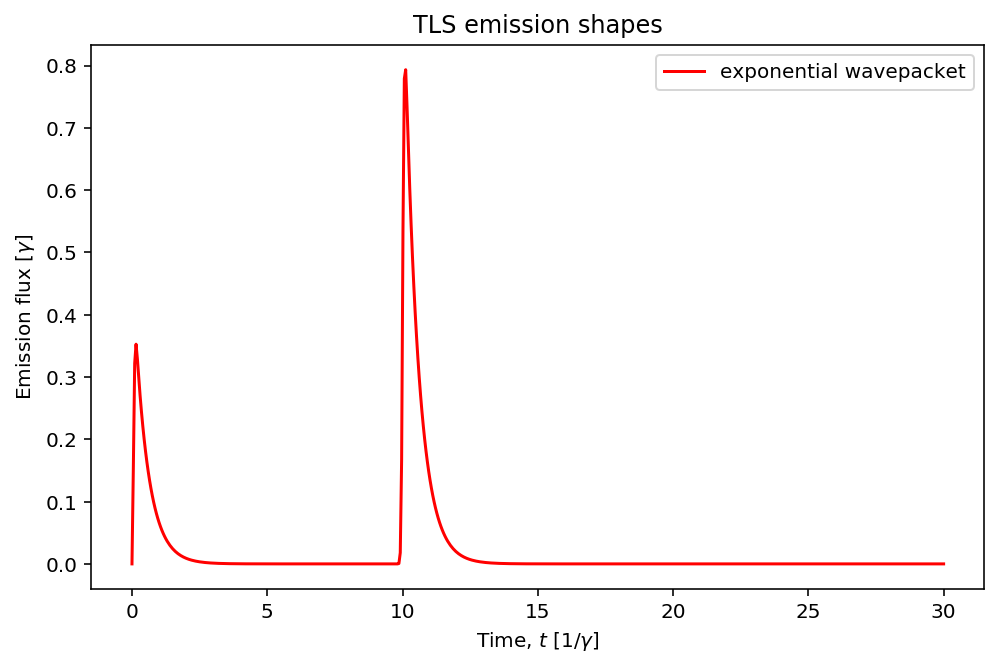

In [9]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(tlist, n_e, 'r', label="exponential wavepacket")
#ax.plot(tlist, n_G, 'b', label="Gaussian wavepacket")
ax.legend()
#ax.set_xlim(0, 13)
#ax.set_ylim(0, 1)
ax.set_xlabel('Time, $t$ [$1/\gamma$]')
ax.set_ylabel('Emission flux [$\gamma$]')
ax.set_title('TLS emission shapes');

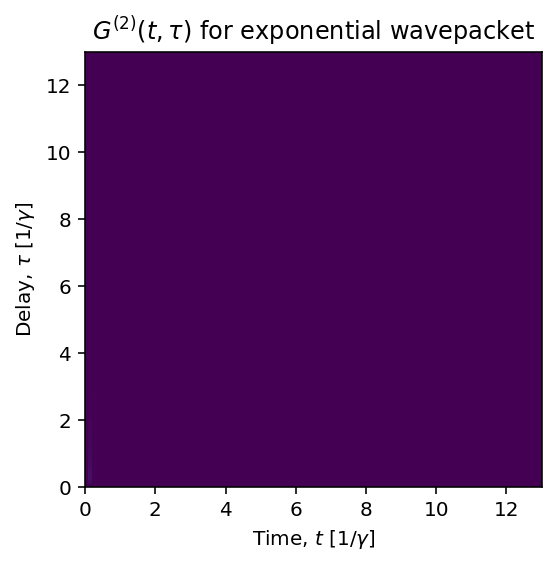

In [10]:
# specify relevant operators to calculate the correlation
# <A(t)B(t+tau)C(t)>
a_op = sm.dag()
b_op = sm.dag() * sm
c_op = sm

# calculate two-time correlations
G2_t_tau_e = correlation_3op_2t(H_e, psi0, tlist, taulist, c_ops,
                                a_op, b_op, c_op)
#G2_t_tau_G = correlation_3op_2t(H_G, psi0, tlist, taulist, c_ops,
 #                               a_op, b_op, c_op)
    
fig = plt.figure(figsize=(9,4))

ax_e = fig.add_subplot(121)
p_e = ax_e.pcolor(tlist*gamma, taulist*gamma,
                  abs(G2_t_tau_e).transpose())
ax_e.set_xlim(0, 13)
ax_e.set_ylim(0, 13)
ax_e.set_xlabel('Time, $t$ [$1/\gamma$]')
ax_e.set_ylabel('Delay, $\\tau$ [$1/\gamma$]')
ax_e.set_title('$G^{(2)}(t,\\tau)$ for exponential wavepacket');

#ax_G = fig.add_subplot(122)
#p_G = ax_G.pcolor(tlist*gamma, taulist*gamma,
    #              abs(G2_t_tau_G).transpose())
#ax_G.set_xlim(0, 13)
#ax_G.set_ylim(0, 13)
#ax_G.set_xlabel('Time, $t$ [$1/\gamma$]')
#ax_G.set_ylabel('Delay, $\\tau$ [$1/\gamma$]')
#ax_G.set_title('$G^{(2)}(t,\\tau)$ for Gaussian wavepacket');

C:\Users\Robin\Anaconda3\lib\site-packages\qutip\correlation.py:814: FutureWarning: correlation_4op_1t() now legacy, please use correlation_3op_1t()
  FutureWarning)


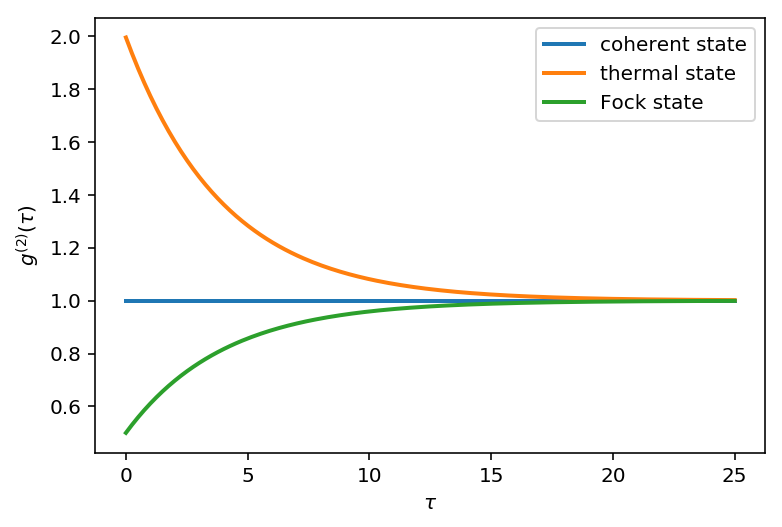

In [8]:
N = 25
taus = np.linspace(0, 25.0, 200)
a = destroy(N)
H = 2 * np.pi * a.dag() * a

kappa = 0.25
n_th = 2.0  # bath temperature in terms of excitation number
c_ops = [np.sqrt(kappa * (1 + n_th)) * a, np.sqrt(kappa * n_th) * a.dag()]

states = [{'state': coherent_dm(N, np.sqrt(2)), 'label': "coherent state"},
          {'state': thermal_dm(N, 2), 'label': "thermal state"},
          {'state': fock_dm(N, 2), 'label': "Fock state"}]

fig, ax = plt.subplots(1, 1)

for state in states:
    rho0 = state['state']

    # first calculate the occupation number as a function of time
    n = mesolve(H, rho0, taus, c_ops, [a.dag() * a]).expect[0]

    # calculate the correlation function G2 and normalize with n(0)n(t) to
    # obtain g2
    G2 = correlation_4op_1t(H, rho0, taus, c_ops, a.dag(), a.dag(), a, a)
    g2 = G2 / (n[0] * n)

    ax.plot(taus, np.real(g2), label=state['label'], lw=2)

ax.legend(loc=0)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$g^{(2)}(\tau)$')
plt.show()